recreate the climatology persistence notebook from [WeatherBench](https://github.com/pangeo-data/WeatherBench/blob/master/notebooks/1-climatology-persistence.ipynb).

# Create climatology and persistence forecasts

In this notebook we will create the most basic baselines: persistence and climatology forecasts. We will do this for 500hPa geopotential, 850hPa temperature, precipitation and 2 meter temperature.

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from benchmark.bm.score import *

In [3]:
res = '5.625'
DATADIR = f'/data/compoundx/WeatherBench/'  # Location of WeatherBench dataset
PREDDIR = '/data/compoundx/WeatherDiff/baselines/'   # Location to store baseline forecasts

In [6]:
# Load the entire dataset for the relevant variables
z500 = xr.open_mfdataset(f'{DATADIR}geopotential_500/*.nc', combine='by_coords').z
t850 = xr.open_mfdataset(f'{DATADIR}temperature_850/*.nc', combine='by_coords').t.drop('level')
# convert to 6 hourly accumulation
tp = xr.open_mfdataset(f'{DATADIR}total_precipitation/*.nc', combine='by_coords').tp.rolling(time=6).sum()
tp.name = 'tp'
t2m = xr.open_mfdataset(f'{DATADIR}2m_temperature/*.nc', combine='by_coords').t2m
data = xr.merge([z500, t850, tp, t2m])

In [10]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
tp_valid = load_test_data(f'{DATADIR}total_precipitation', 'tp').rolling(time=6).sum()
tp_valid.name = 'tp'
t2m_valid = load_test_data(f'{DATADIR}2m_temperature', 't2m')
valid_data = xr.merge([z500_valid, t850_valid, tp_valid, t2m_valid], compat="override")

# Persistence

Persistence simply means: Tomorrow's weather is today's weather.

In [11]:
def create_persistence_forecast(ds, lead_time_h):
    assert lead_time_h > 0, 'Lead time must be greater than 0'
    ds_fc = ds.isel(time=slice(0, -lead_time_h))
    return ds_fc

In [12]:
lead_times = xr.DataArray(
    np.arange(6, 126, 6), dims=['lead_time'], coords={'lead_time': np.arange(6, 126, 6)}, name='lead_time')

In [13]:
persistence = []
for l in lead_times:
    persistence.append(create_persistence_forecast(valid_data, int(l)))
persistence = xr.concat(persistence, dim=lead_times)

In [14]:
persistence

<xarray.Dataset>
Dimensions:    (lon: 64, lat: 32, time: 17514, lead_time: 20)
Coordinates:
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T17:00:00
    level      int32 500
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Data variables:
    z          (lead_time, time, lat, lon) float32 dask.array<chunksize=(1, 8760, 32, 64), meta=np.ndarray>
    t          (lead_time, time, lat, lon) float32 dask.array<chunksize=(1, 8760, 32, 64), meta=np.ndarray>
    tp         (lead_time, time, lat, lon) float32 dask.array<chunksize=(1, 8765, 32, 64), meta=np.ndarray>
    t2m        (lead_time, time, lat, lon) float32 dask.array<chunksize=(1, 8760, 32, 64), meta=np.ndarray>
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [16]:
# Save the predictions
persistence.to_netcdf(f'{PREDDIR}persistence_{res}.nc')

# Climatology

First let's create a single climatology from the entire training dataset (meaning everything before 2017).

In [18]:
def create_climatology_forecast(ds_train):
    return ds_train.mean('time')

In [19]:
train_data = data.sel(time=slice(None, '2016'))

In [20]:
climatology = create_climatology_forecast(train_data)

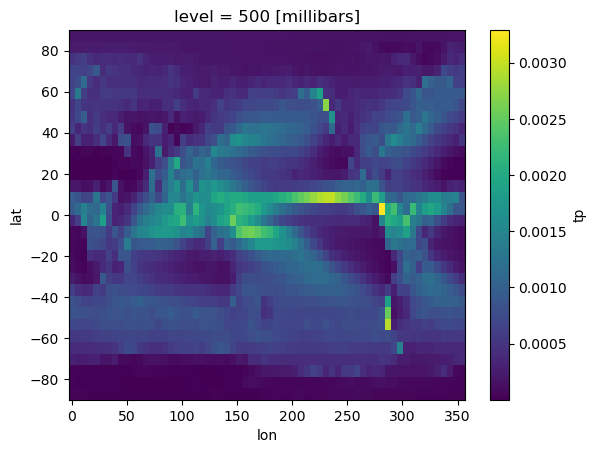

In [23]:
climatology.tp.plot();

In [24]:
climatology.to_netcdf(f'{PREDDIR}climatology_{res}.nc')

# Climatology by week

We can create amuch better climatology by taking the seasonal cycle into account. Here we will do this by creating a separate climatology for every week.

In [25]:
def create_weekly_climatology_forecast(ds_train, valid_time):
    ds_train['week'] = ds_train['time.week']
    weekly_averages = ds_train.groupby('week').mean('time')
    valid_time['week'] = valid_time['time.week']
    fc_list = []
    for t in valid_time:
        fc_list.append(weekly_averages.sel(week=t.week))
    return xr.concat(fc_list, dim=valid_time)

In [26]:
weekly_climatology = create_weekly_climatology_forecast(train_data, valid_data.time)

/home/wider/.conda/envs/TORCH311/lib/python3.11/site-packages/xarray/core/accessor_dt.py:408: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/wider/.conda/envs/TORCH311/lib/python3.11/site-packages/xarray/core/accessor_dt.py:408: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


In [27]:
weekly_climatology.to_netcdf(f'{PREDDIR}weekly_climatology_{res}.nc')

In [29]:
z500_valid.time

<xarray.DataArray 'time' (time: 17520)>
array(['2017-01-01T00:00:00.000000000', '2017-01-01T01:00:00.000000000',
       '2017-01-01T02:00:00.000000000', ..., '2018-12-31T21:00:00.000000000',
       '2018-12-31T22:00:00.000000000', '2018-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    level    int32 500
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Attributes:
    long_name:  time